# <center>CITS5508 Lab 2: Bean Classification</center>

**Name:** Chitra M Saraswati<br>
**Student ID:** 21367076<br>

In this workbook we classify beans of seven different varieties. Specifically, we use a Support Vector Classifier and a Stochastic Gradient Descent Classifier and then compare the performance of these two classification methods.

As per the data description:<br>
"Seven different types of dry beans were used in this research, taking into account the features such as form, shape, type, and structure by the market situation. A computer vision system was developed to distinguish seven different registered varieties of dry beans with similar features in order to obtain uniform seed classification. For the classification model, images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. Bean images obtained by computer vision system were subjected to segmentation and feature extraction stages, and a total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains."

You can also find the relevant paper below:<br>
KOKLU, M. and OZKAN, I.A., (2020), “Multiclass Classification of Dry Beans Using Computer Vision and Machine Learning Techniques.” Computers and Electronics in Agriculture, 174, 105507. DOI: https://doi.org/10.1016/j.compag.2020.105507

In [1]:
# Common imports
import os
import numpy as np
import pandas as pd

# To ensure stable output across runs
np.random.seed(35)

# For pretty plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
bean_path = os.path.join('DryBeanDataset', 'Dry_Bean_Dataset.xlsx')
os.path.exists(bean_path)

True

## 1. Import data; EDA

In [3]:
from openpyxl import load_workbook
wb = load_workbook(bean_path)

from openpyxl.utils.dataframe import dataframe_to_rows
sheet = wb.active
data = sheet.values
cols = next(data)[0:]
df = pd.DataFrame(data, columns = cols)

In [4]:
df.head(3)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER


### Exploratory Data Analysis

An explanation of the attributes for this data can be found in the data description. I also thought it was a good idea to go to the paper and have a look at the beans myself. If you refer to the paper, we see that the Bombay and Seker varieties are the most visually distinctive from the other varieties due to their area and roundedness.

As our ML algorithms won't be taking colour into consideration, the Barbunya beans wouldn't be as distinctive to our algorithms as we visually judge them to be.

<img src="bean-varieties.jpg">

<img src="beans-all-together.jpg">

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

In [ ]:
# Check for any NA values
sample_incomplete_rows = df[df.isnull().any(axis=1)].head()
sample_incomplete_rows

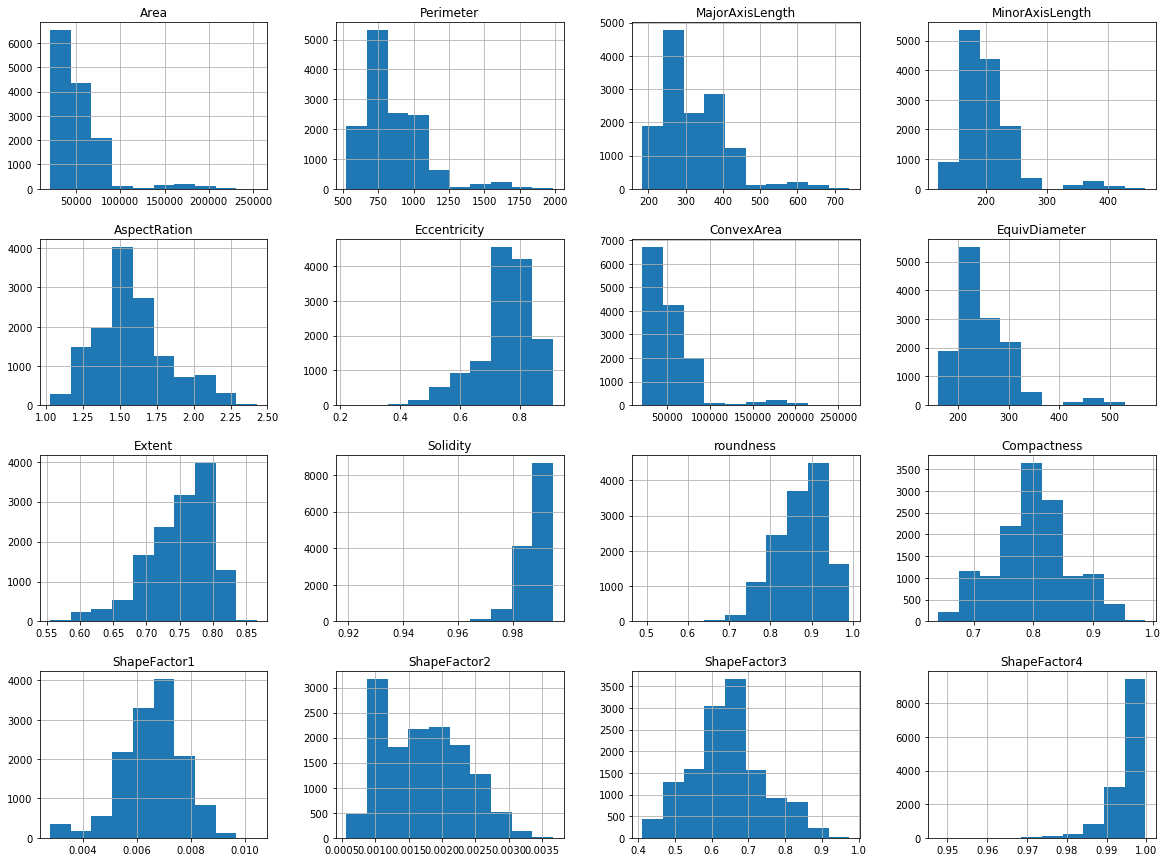

In [6]:
df.hist(figsize = (20,15))
plt.show()

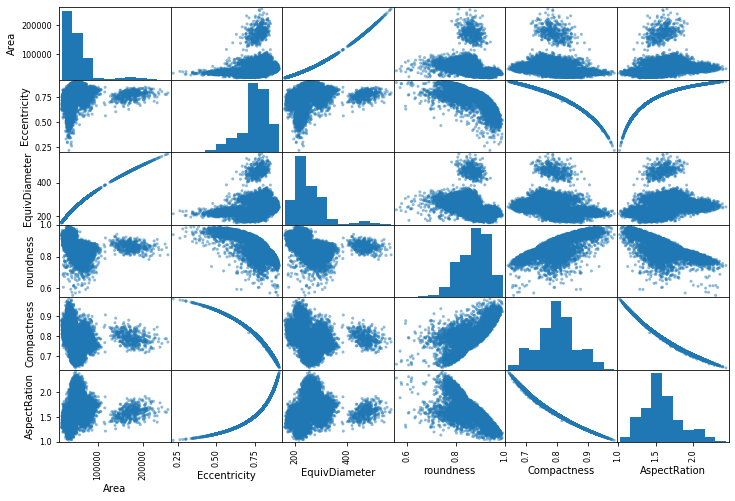

In [63]:
# Creating a scatter plot matrix for the six most interesting attributes:
# Area, eccentricity, equivalent diameter, roundness, compactness, and aspect ratio.

from pandas.plotting import scatter_matrix

bean_attr = ["Area", "Eccentricity", "EquivDiameter", 
             "roundness", "Compactness", "AspectRation"]
scatter_matrix(df[bean_attr], figsize = (12, 8))
plt.show()

The scatter plot matrix above indicates that we may be interested on classifying on equivalent diameter and area. These features are very different. 

But it's not a good idea to do the classification on the features which are pretty much perfectly correlated, such as:
* eccentricity vs compactness
* eccentricity vs aspect ratio
* area vs equivalent diameter
* compactness vs aspect ratio

# 2. Viewing class imbalances

In [8]:
df["Class"].value_counts()

DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: Class, dtype: int64

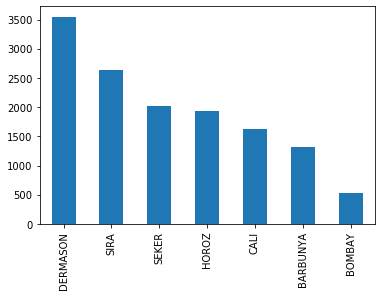

In [9]:
df["Class"].value_counts().plot(kind='bar')

We see that 

# 3. Split to training set and test set

In [10]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 35)

In [54]:
print("Training set:", len(train_set.index), "and testing set:", len(test_set.index))

Training set: 10888 and testing set: 2723


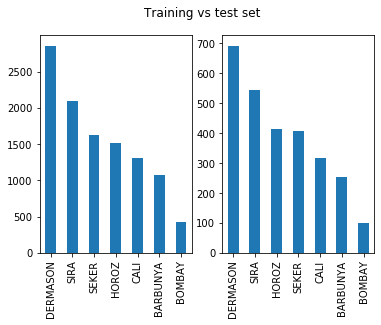

In [13]:
# Checking for class imbalances in training set vs test set

fig, (subpl1, subpl2) = plt.subplots(1, 2)
fig.suptitle("Training vs test set")

train_set["Class"].value_counts().plot(kind="bar", ax=subpl1)
test_set["Class"].value_counts().plot(kind="bar", ax=subpl2)

# 4. Data preparation: feature scaling

To prepare our data for our machine learning alogrithms, we'll scale our data using min-max scaling. We'll be using min-max scaling as we don't really have outliers (as per the histograms and scatter plots; refer to EDA in section one). Additionally, SGD is sensitive to feature scaling so we'll stick to using min-max scaling.

In [14]:
# Now we only use the training set
df = train_set
df.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
3817,203686,1722.932,660.997605,394.684760,1.674748,0.802163,206087,509.255407,0.790961,0.988350,0.862253,0.770435,0.003245,0.000705,0.593569,0.994079,BOMBAY
6141,50781,907.117,366.984978,178.103315,2.060517,0.874339,51606,254.276183,0.630483,0.984013,0.775505,0.692879,0.007227,0.001027,0.480081,0.989216,HOROZ
6090,50253,872.982,354.074847,181.355633,1.952379,0.858869,50859,252.950799,0.641604,0.988085,0.828631,0.714399,0.007046,0.001132,0.510366,0.996428,HOROZ
7130,60868,1018.898,416.225028,187.510757,2.219739,0.892775,61982,278.387400,0.760869,0.982027,0.736779,0.668839,0.006838,0.000844,0.447345,0.992990,HOROZ
6625,55106,927.101,371.976078,190.338253,1.954290,0.859167,55705,264.883254,0.776360,0.989247,0.805665,0.712098,0.006750,0.001071,0.507083,0.990987,HOROZ


In [16]:
# Select numeric variables only
df_num = df.select_dtypes(include=[np.number])

In [17]:
# We use the min-max scaler as there doesn't seem to be extreme outliers 
# (as per histogram and scatter plots; see EDA in section 1).

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

x_train = minmax.fit_transform(df_num)
x_train

array([[0.78253258, 0.82032597, 0.85977256, ..., 0.04550786, 0.32463071,
        0.89178084],
       [0.12963928, 0.26179111, 0.33026717, ..., 0.14940349, 0.12356341,
        0.79829134],
       [0.12738475, 0.23842112, 0.30701652, ..., 0.18314935, 0.17721938,
        0.93693095],
       ...,
       [0.11086013, 0.20256272, 0.22139572, ..., 0.33739788, 0.38653996,
        0.83707605],
       [0.08775983, 0.17713609, 0.15199351, ..., 0.504547  , 0.55988531,
        0.97418321],
       [0.1138747 , 0.21871187, 0.28868212, ..., 0.19145305, 0.17119569,
        0.80617175]])

In [18]:
x_train.shape

(10888, 16)

In [19]:
# View it in panda's data frame format, just to check
pd_num_tr = pd.DataFrame(x_train)
pd_num_tr.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.782533,0.820326,0.859773,0.801744,0.462404,0.842218,0.764306,0.852697,0.757999,0.916110,0.704018,0.374526,0.066303,0.045508,0.324631,0.891781
1,0.129639,0.261791,0.330267,0.146331,0.736887,0.946448,0.127473,0.227948,0.241792,0.858626,0.504100,0.150846,0.631397,0.149403,0.123563,0.798291
2,0.127385,0.238421,0.307017,0.156173,0.659944,0.924106,0.124393,0.224700,0.277565,0.912599,0.626534,0.212913,0.605713,0.183149,0.177219,0.936931
3,0.172710,0.338320,0.418947,0.174800,0.850177,0.973070,0.170247,0.287025,0.661202,0.832292,0.414855,0.081511,0.576237,0.090284,0.065565,0.870836
4,0.148107,0.275473,0.339256,0.183356,0.661304,0.924537,0.144371,0.253937,0.711030,0.928006,0.573607,0.206275,0.563752,0.163344,0.171402,0.832335


In [46]:
# Do the same for the testing set
test_num = test_set.select_dtypes(include=[np.number])

x_test = minmax.fit_transform(test_num)
x_test

array([[0.16310499, 0.31194525, 0.38082098, ..., 0.12744597, 0.06479199,
        0.93098137],
       [0.05478535, 0.10196431, 0.11730625, ..., 0.54956896, 0.45245857,
        0.9181154 ],
       [0.13713795, 0.25994586, 0.32443083, ..., 0.17680027, 0.11618547,
        0.79342807],
       ...,
       [0.17827788, 0.30977276, 0.35339881, ..., 0.18989403, 0.18905444,
        0.92695095],
       [0.05152675, 0.10245844, 0.11523963, ..., 0.54356051, 0.43686455,
        0.97276763],
       [0.26447583, 0.40605307, 0.43497149, ..., 0.16670521, 0.24012091,
        0.74798854]])

In [47]:
x_test.shape

(2723, 16)

# 5. Using the Support Vector Classifier

## 5.1 Train the model

In [ ]:
#QN What's the rbf kernel for SVC? Use GridSearchCV to find the best hyperparemeters?

In [20]:
y_train = train_set["Class"]

from sklearn.svm import SVC
svc = SVC(kernel="rbf")
svc.fit(x_train, y_train)

SVC()

In [40]:
#QN If I predict SVC in CV [cell below], is it still predicting SVC? Or is training v different from CV?
y_pred_svc = svc.predict(x_train)

In [39]:
svc.classes_

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'],
      dtype=object)

## 5.2 Cross-validate

In [ ]:
##TODO Insert precision and recall in here?

In [55]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

y_pred_svc = cross_val_predict(svc, x_train, y_train)
cm_svc = confusion_matrix(y_train, y_pred_svc)
cm_svc

array([[ 945,    1,   77,    0,    5,    9,   32],
       [   0,  422,    0,    0,    0,    0,    0],
       [  24,    0, 1252,    0,   19,    2,   17],
       [   1,    0,    0, 2623,    3,   49,  179],
       [   3,    0,   25,   15, 1443,    0,   30],
       [  13,    0,    0,   27,    1, 1524,   56],
       [   7,    0,    2,  205,   34,   22, 1821]])

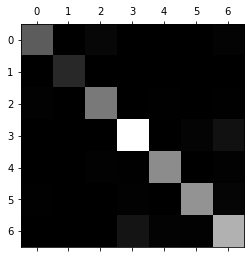

In [56]:
# Confusion matrix for correct classification
plt.matshow(cm_svc, cmap = plt.cm.gray)
plt.show()

The confusion matrix here looks quite good as most values are on the main diagonal, i.e. they were classified correctly (the darker the square, the less values there were classified in that category).

The Bombay variety (class 1 in the plot) looks darker than the other varieties; indeed, there were fewer Bombay beans than there were other varieties (refer to the section on EDA in Part 1). We could also check if the classifier does not perform as well on the Bombay than for the other varieties.

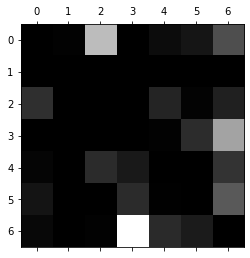

In [58]:
# Focusing on plotting the errors
row_sums = cm_svc.sum(axis=1, keepdims=True)
ncm_svc = cm_svc / row_sums
np.fill_diagonal(ncm_svc, 0)
plt.matshow(ncm_svc, cmap=plt.cm.gray)
plt.show()

From textbook:

"The column for class 8 is quite bright, which tells you that many images get misclassified as 8s. However, the row for class 8 is not that bad, telling you that actual 8s in general get properly classified as 8s. As you can see, the confusion matrix is not necessarily symmetrical. You can also see that 3s and 5s often get confused (in both directions) [v bright]."

The rows and columns for the Bombay bean (class 1) is dark, indicating that Bombay beans tend to get classified correctly. After Bombay beans come the Seker beans (class 5); they also tend to get classified correctly, even though not to the same extent.

Barbunya and Cali beans (classes 0 and 2 respectively) tend to get confused for each other, in both directions–moreso Cali beans being confused for Barbunya beans. This is also the case for Dermason (class 3) and Sira (class 6) beans.

# 6. Using the Stochastic Gradient Descent Classifier

Basically a linear regression model.. but slowly

Also–it's called 'stochastic' because we randomly sample from the training set and calculate the gradient only for that instance, rather than calculating the gradient at every instance. Especially useful for large data sets.

## 6.1 Train the SGD Classifier

In [26]:
y_train = train_set["Class"]
y_train

3817      BOMBAY
6141       HOROZ
6090       HOROZ
7130       HOROZ
6625       HOROZ
          ...   
3007    BARBUNYA
7148       HOROZ
9143        SIRA
1295       SEKER
5833       HOROZ
Name: Class, Length: 10888, dtype: object

In [27]:
from sklearn.linear_model import SGDClassifier

sgdc = SGDClassifier(random_state = 35)
sgdc.fit(x_train, y_train)

SGDClassifier(random_state=35)

In [29]:
score = sgdc.score(x_train, y_train)
print("Training score: ", score) 

Training score:  0.9003490080822925


In [59]:
y_pred_sgdc = sgdc.predict(x_train)

cm_sgdc = confusion_matrix(y_train, y_pred_sgdc)
print(cm_sgdc)

[[ 842    0  159    0    3   17   48]
 [   0  414    7    0    0    1    0]
 [   2    0 1288    0    9    2   13]
 [   5    0    0 2576    1   65  208]
 [   4    0   98   17 1357    0   40]
 [  26    0    1   14    0 1515   65]
 [  10    0   28  206   13   23 1811]]


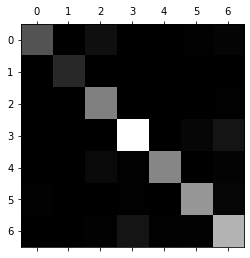

In [62]:
plt.matshow(cm_sgdc, cmap = plt.cm.gray)
plt.show()

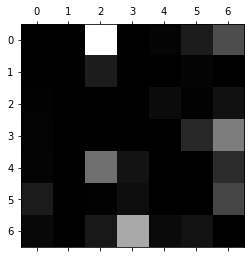

In [61]:
row_sums = cm_sgdc.sum(axis=1, keepdims=True)
ncm_sgdc = cm_sgdc / row_sums
np.fill_diagonal(ncm_sgdc, 0)
plt.matshow(ncm_sgdc, cmap=plt.cm.gray)
plt.show()

## 6.2 Cross-validate

In [35]:
#QN-ME: what does cv=3 below indicate for cross_val_score?
# It is how many k-folds; in this instance, 3. Default is 5-fold
from sklearn.model_selection import cross_val_score
cross_val_score(sgdc, x_train, y_train, cv=3, scoring="accuracy")

array([0.89862259, 0.90410581, 0.89887021])

# 7. Comparing the two classifiers

We will now compare the two classifiers' confusion matrices side by side.

In [ ]:
#QN
# 1. [Gian] How do I plot [24] and [30] i.e. the confusion matrices side by side considering they don't have a 'plot' command?
# 2. [Me] What exactly does the confusion matrix show? CM of testing vs training set?
# 3. What hyperparameters for both SGD and SCV? They don't seem to need any?

TypeError: inner() got multiple values for argument 'ax'

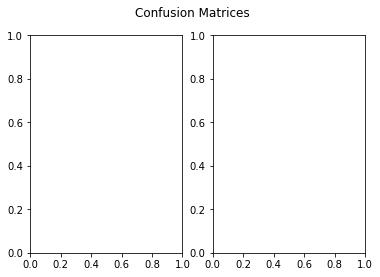

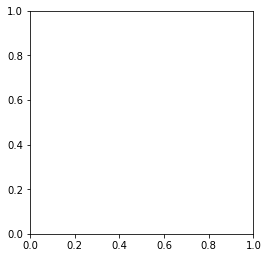

In [65]:
fig, (subpl1, subpl2) = plt.subplots(1, 2)
fig.suptitle("Confusion Matrices")

plt.matshow(cm_svc, cmap = plt.cm.gray)
plt.show(ax=subpl1)

plt.matshow(cm_sgdc, cmap = plt.cm.gray)
plt.show(ax=subpl2)